In [1]:
import tensorflow as tf
import random
import sys
import numpy as np
from numpy import float32
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl

np.random.seed(678)
tf.set_random_seed(768)

/Users/mgibson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Activation Functions - however there was no indication in the original paper
def tf_log(x): return tf.sigmoid(x)
def d_tf_log(x): return tf.multiply(tf_log(x),tf.subtract(1.0,tf_log(x))) 
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf.square(tf_tanh(x))
def tf_softmax(x): return tf.nn.softmax(x)

In [3]:
# -1. DNA encode table
protein_table = {"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
           "TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
           "TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V",
           "TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V",
           "TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
           "TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
           "TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
           "TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
           "TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
           "TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
            "CAA" : "Q", "AAA" : "K", "GAA" : "E",
            "CAG" : "Q", "AAG" : "K", "GAG" : "E",
           "TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
           "TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
            "CGA" : "R", "AGA" : "R", "GGA" : "G",
           "TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G" 
           }

In [12]:
# 0. Generate Random Data of dna to convert to Protein
num_training_data = 2000
length_of_protein = 2

proportion_rate = 1500
decay_rate = 0.008
compare_range = 100

learning_rate = 0.0009
# above safe
# learning_rate = 0.001

beta_1 ,beta_2= 0.9, 0.999
adam_e = 0.00000001

num_epoch = 1201
print_size = 200
batch_size = 100

hidden_layers = 50

In [15]:
# 1. Array to Contain all of the data 
dna_data = np.array([])
protein_data = np.array([])
dna_data_real = np.array([])

for training_index in range(num_training_data):
    
    current_data = np.array([])
    protein_sequence = np.array([])
    
    for _ in range(length_of_protein):
        dna,protein = random.choice(list(protein_table.items()))
        dna_data_real = np.append(dna_data_real,dna)
        for d in dna:
            if   d == "A":
                current_data = np.append(current_data,np.array([0,0,0,1]).T)
            elif d == "C":
                current_data = np.append(current_data,np.array([0,0,1,0]).T)
            elif d == "G":
                current_data = np.append(current_data,np.array([0,1,0,0]).T)
            elif d == "T":
                current_data = np.append(current_data,np.array([1,0,0,0]).T)
        protein_sequence = np.append(protein_sequence,[protein])

    if training_index == 0 :
        dna_data = np.expand_dims(current_data,axis=0)
        protein_data = np.expand_dims(protein_sequence,axis=0)
    else:
        dna_data = np.vstack((dna_data,np.expand_dims(current_data,axis=0)))
        protein_data = np.vstack((protein_data,np.expand_dims(protein_sequence,axis=0)))
        
protein_data
dna_data

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(protein_data)
groud_truth_table  = protein_data
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
protein_data = onehot_encoder.fit_transform(integer_encoded)

print('------ One Hot Encoded Protein Data-----')
print(dna_data.shape)
print(protein_data.shape)

In [ ]:
# 2. Make the class
class FCNN:
    
    def __init__(self,input=None,output=None,act=None,d_act=None,random_seed =None):

        self.w = tf.Variable(tf.random_normal([input,output],seed=random_seed))

        self.activation = act
        self.d_activation = d_act
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))

        self.input,self.layer,self.layerA= None,None,None

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer  = tf.matmul(self.input,self.w)
        self.layerA = self.activation(self.layer)
        return self.layerA
    
    def backprop(self,gradient=None):
        
        grad_part_1 = gradient
        grad_part_2 = self.d_activation(self.layer) 
        grad_part_3 = self.input

        grad = tf.matmul(tf.transpose(grad_part_3),tf.multiply(grad_part_1,grad_part_2))
        grad_pass = tf.matmul(tf.multiply(grad_part_1,grad_part_2),tf.transpose(self.w))

        assign = []
        assign.append(tf.assign(self.m,beta_1*self.m + (1.0-beta_1)*grad))
        assign.append(tf.assign(self.v,beta_2*self.v + (1.0-beta_2)*tf.square(grad) ))    

        m_hat = tf.divide(self.m, tf.subtract(1.0,beta_1) )
        v_hat = tf.divide(self.v, tf.subtract(1.0,beta_2) )

        adam_middle = tf.divide(learning_rate,tf.add(tf.sqrt(v_hat),adam_e))
        assign.append(  tf.assign(self.w, tf.subtract(self.w,tf.multiply(adam_middle,m_hat)))  )

        return grad_pass,assign

In [9]:
# 3.Make the Layers
random_seed_number = np.random.randint(10)
layer1 = FCNN(12,hidden_layers,tf_log,d_tf_log,random_seed_number)
layer2 = FCNN(hidden_layers,hidden_layers,tf_log,d_tf_log,random_seed_number)
layer3 = FCNN(hidden_layers,hidden_layers,tf_log,d_tf_log,random_seed_number)
layer4 = FCNN(hidden_layers,20,tf_log,d_tf_log,random_seed_number)

In [10]:
# 4. Make the graph
x = tf.placeholder(shape=[None,12],dtype=tf.float32)
y = tf.placeholder(shape=[None,20],dtype=tf.float32)
iter_variable_dil = tf.placeholder(tf.float32, shape=())
decay_propotoin_rate = proportion_rate / (1 + decay_rate * iter_variable_dil)

l1 = layer1.feedforward(x)
l2 = layer2.feedforward(l1)
l3 = layer3.feedforward(l2)
l4 = layer4.feedforward(l3)
final_soft = tf_softmax(l4)

cost = tf.reduce_sum(-1.0 * (y* tf.log(final_soft) + (1-y)*tf.log(1-final_soft)))
correct_prediction = tf.equal(tf.argmax(final_soft, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

l4g,l4update = layer4.backprop(final_soft - y)
l3g,l3update = layer3.backprop(l4g)
l2g,l2update = layer2.backprop(l3g+decay_propotoin_rate*l4g)
l1g,l1update = layer1.backprop(l2g+decay_propotoin_rate*(l4g+l3g))
weight_updates = l4update + l3update + l2update + l1update

avg_over_time =[]
cost_over_time =[]

Current Iter:  0  Current acuuracy:  0.03  current cost:  392.28644

Avg Accuracy for iter:  0  acc:  0.0364999994635582
Current Iter:  200  Current acuuracy:  0.93  current cost:  304.48712Current acuuracy:  0.22  current cost:  360.62778  Current acuuracy:  0.15  current cost:  348.5708329  Current acuuracy:  0.72  current cost:  328.279850.83  current cost:  318.264770.84  current cost:  311.91852  Current acuuracy:  0.75  current cost:  316.4824 89  Current acuuracy:  0.85  current cost:  310.25928  Current acuuracy:  0.92  current cost:  307.503720.93  current cost:  308.22375 current cost:  307.05658 307.1989  Current acuuracy:  0.91  current cost:  307.759  Current acuuracy:  0.88  current cost:  310.0102 current cost:  306.976620.9  current cost:  307.25824  current cost:  304.1897 188  Current acuuracy:  0.9  current cost:  308.20923 current cost:  308.03217

Avg Accuracy for iter:  200  acc:  0.9215000003576279
Current Iter:  400  Current acuuracy:  0.93  current cost:  302.7

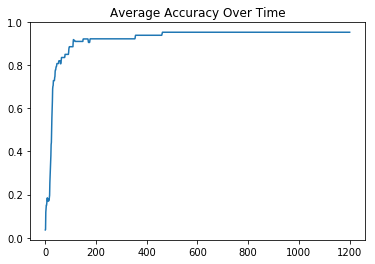

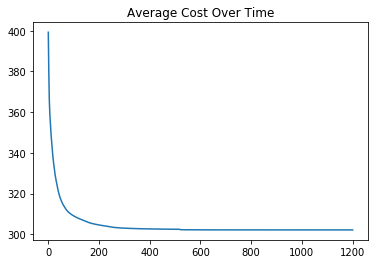

Current DNA:  TTT  Encoded DNA:  [[1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]]
Current Protein:  F  Encoded Protein Class:  4  Prediceted Protein Class:  4
-----------
Current DNA:  CTT  Encoded DNA:  [[0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]]
Current Protein:  L  Encoded Protein Class:  9  Prediceted Protein Class:  9
-----------
Current DNA:  ATT  Encoded DNA:  [[0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]]
Current Protein:  I  Encoded Protein Class:  7  Prediceted Protein Class:  7
-----------
Current DNA:  GTT  Encoded DNA:  [[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]]
Current Protein:  V  Encoded Protein Class:  17  Prediceted Protein Class:  17
-----------
Current DNA:  TTC  Encoded DNA:  [[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]
Current Protein:  F  Encoded Protein Class:  4  Prediceted Protein Class:  4
-----------
Current DNA:  CTC  Encoded DNA:  [[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]
Current Protein:  L  Encoded Protein Class:  9  Prediceted Protein Class:  9
-----------
Current DNA:  ATC  Encoded

In [11]:
# 5. Train
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    avg_accuracy  = 0
    avg_cost = 0

    for iter in range(num_epoch):
        
        for batch_index in range(0,len(protein_data),batch_size):
            
            current_batch = dna_data[batch_index:batch_index+batch_size,:]
            current_batch_label = protein_data[batch_index:batch_index+batch_size,:]

            sess_results = sess.run([accuracy,cost,weight_updates,correct_prediction],feed_dict={x:current_batch, y:current_batch_label, iter_variable_dil:iter})
            
            print("Current Iter: ", iter, " Current acuuracy: ", sess_results[0], " current cost: ",sess_results[1], end='\r')
            avg_accuracy = avg_accuracy + sess_results[0]
            avg_cost     = avg_cost + sess_results[1]

        if iter %print_size==0:
            print('\n')
            print("Avg Accuracy for iter: ", iter, " acc: ", avg_accuracy/(len(protein_data)/batch_size))

        avg_over_time.append(avg_accuracy/(len(protein_data)/batch_size))
        cost_over_time.append(avg_cost/(len(protein_data)/batch_size))
        
        avg_cost = 0
        avg_accuracy = 0

    # Show the Training Graph
    plt.figure()
    plt.plot(range(len(avg_over_time)),avg_over_time)
    plt.title("Average Accuracy Over Time")
    plt.show()

    plt.figure()
    plt.plot(range(len(cost_over_time)),cost_over_time)
    plt.title("Average Cost Over Time")
    plt.show()

    # Get the list of every DNA Sequence
    for all_dna in protein_table:
        
        ground_truth_protein  = protein_table[all_dna]

        current_data = np.array([])
        for d in all_dna:
            if   d == "A":
                current_data = np.append(current_data,np.array([0,0,0,1]).T)
            elif d == "C":
                current_data = np.append(current_data,np.array([0,0,1,0]).T)
            elif d == "G":
                current_data = np.append(current_data,np.array([0,1,0,0]).T)
            elif d == "T":
                current_data = np.append(current_data,np.array([1,0,0,0]).T)

        current_data= np.expand_dims(current_data,axis=0)
        sess_results = sess.run([final_soft],feed_dict={x:current_data})

        gt_index = np.where(groud_truth_table==ground_truth_protein)[0]
        gt_vector = protein_data[gt_index[0]]

        print("Current DNA: ", all_dna, " Encoded DNA: ", current_data)
        print("Current Protein: ", ground_truth_protein, " Encoded Protein Class: ", np.argmax(gt_vector)," Prediceted Protein Class: ", np.argmax(sess_results[0])  )
        # print(" Encoded Protein Vector: ", gt_vector,' Predicted Vector: ', sess_results[0])
        print('-----------')
        